# Importing and Data Prep

In [0]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth
from google.colab import drive
import pickle
from sklearn.utils import resample
import pandas as pd
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import torch
import torchvision.transforms as transforms
import numpy as np
from torch import nn

from sklearn.metrics import confusion_matrix
import seaborn as sn

In [0]:
# install kaggle to access dataset
!pip install kaggle
# enable kaggle API
# note: you NEED to have your kaggle token saved in drive for this to work (https://github.com/Kaggle/kaggle-api)
auth.authenticate_user()
drive_service = build('drive', 'v3')
results = drive_service.files().list(q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])
filename = "/root/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)
request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100));
os.chmod(filename, 600)
from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()
# download HASYV2 dataset
api.dataset_download_files('guru001/hasyv2')
# unzip data
!unzip hasyv2.zip

流式输出内容被截断，只能显示最后 5000 行内容。
  inflating: hasyv2/hasy-data/v2-95012.png  
  inflating: hasyv2/hasy-data/v2-95013.png  
  inflating: hasyv2/hasy-data/v2-95014.png  
  inflating: hasyv2/hasy-data/v2-95015.png  
  inflating: hasyv2/hasy-data/v2-95016.png  
  inflating: hasyv2/hasy-data/v2-95017.png  
  inflating: hasyv2/hasy-data/v2-95018.png  
  inflating: hasyv2/hasy-data/v2-95019.png  
  inflating: hasyv2/hasy-data/v2-95020.png  
  inflating: hasyv2/hasy-data/v2-95021.png  
  inflating: hasyv2/hasy-data/v2-95022.png  
  inflating: hasyv2/hasy-data/v2-95023.png  
  inflating: hasyv2/hasy-data/v2-95024.png  
  inflating: hasyv2/hasy-data/v2-95025.png  
  inflating: hasyv2/hasy-data/v2-95026.png  
  inflating: hasyv2/hasy-data/v2-95027.png  
  inflating: hasyv2/hasy-data/v2-95028.png  
  inflating: hasyv2/hasy-data/v2-95029.png  
  inflating: hasyv2/hasy-data/v2-95030.png  
  inflating: hasyv2/hasy-data/v2-95031.png  
  inflating: hasyv2/hasy-data/v2-95032.png  
  inflating: hasyv2/hasy-dat

In [0]:
# creating own DatasetClass (this is like an ImageFolder, except custom so that we don't have to arrange images in a directory by label)
class SymbolsDataset(Dataset):
    def __init__(self, labels_path, imgs_path, indices, size):
        """
        Initialize data set as a list of IDs corresponding to each item of data set
        :param img_dir: path to image files as a uncompressed tar archive
        :param txt_path: a text file containing names of all of images line by line
        """
        # Read in the dataframe
        data = pd.read_csv(labels_path, sep=',', index_col=0)
        
        # Convert the column into a list
        master_list = []
        for i in range(168233):
          master_list.append(data.iloc[i, 1])

        # Extract just the unique values (i.e. the set)
        unique = np.unique(master_list)

        # Create a mapping between each symbol and an ID in [0,...,368]
        dict_id = {}
        i = 0
        for symbol in unique:
          dict_id[symbol] = i
          i = i + 1

        # Add an class_id column to represent the class for each
        data["class_id"] = 0

        # Iterate through the dataframe and add in the new id
        for i in range(168233):
          data.iloc[i, 3] = dict_id[data.iloc[i, 1]]

        # Finally, declare self.df
        self.df = data.iloc[indices,:] # use data, but only at relevant indices to either train/test/validate
        self.img_names = self.df.index.values
        self.labels_path = labels_path
        self.imgs_path = imgs_path
        #self.transform = transforms.Compose([transforms.ToTensor()])
        if size == 32:
          self.transform = transforms.Compose([transforms.ToTensor()])
        else: # Only normalize and resize and so forth if it's non-standard (i.e. not 32x32)
          self.transform = transforms.Compose([transforms.Resize(size), transforms.ToTensor(), 
                                             transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    def get_image_from_folder(self, name):
        """
        gets a image by a name gathered from file list text file
        :param name: name of targeted image
        :return: a PIL image
        """
        image = Image.open(os.path.join(self.imgs_path, name))
        return image

    def __len__(self):
        """
        Return the length of data set using list of IDs
        :return: number of samples in data set
        """
        return len(self.img_names)

    def __getitem__(self, index):
        """
        Generate one item of data set. 
        """
        img = self.get_image_from_folder(self.img_names[index])
        img = img.convert('RGB') 
        img = self.transform(img)
        #img = np.squeeze(img)
        #lbl = self.df.iloc[index][1]
        lbl = torch.tensor(self.df.iloc[index][3])

        return (img, lbl)

In [0]:
drive.mount('/content/drive')
############### CHANGE BELOW PATH #################
# change the path that the .pkl files are in according to your directory

# With grayscale only
DATA_PATH = "/content/drive/My Drive/APS 360 Project/Symbols Dataset (Balanced - 700 Classes) Greyscale/"
infile = open(DATA_PATH+'train_dataset_2_L.pkl','rb')
train_dataset = pickle.load(infile)
infile = open(DATA_PATH+'test_dataset_2_L.pkl','rb')
test_dataset = pickle.load(infile)
infile = open(DATA_PATH+'val_dataset_2_L.pkl','rb')
val_dataset = pickle.load(infile)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Double check size is same as below
# For new larger dataset (700/class):
tot = len(train_dataset) + len(val_dataset) + len(test_dataset)
print("Total number of records: ", tot)
delta = tot - 168233
print("There are now ", delta, " new records")

Total number of records:  258300
There are now  90067  new records


In [0]:
# Make data loader
# Create a dummy data loader for the purposes of printing some images
data_loader = torch.utils.data.DataLoader(train_dataset,
                                          batch_size=1,
                                          shuffle=True,
                                          num_workers=1)

In [0]:
# Define the loaders for the model training and testing
batch_size=256 # can change this

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
validation_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

In [0]:
# Pytorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim #for gradient descent

# Functions

**Run everything in this section before proceeding to training / analysis**

## Training Functions

In [0]:
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

In [0]:
# Implement function for getting model accuracy

def get_accuracy(model, data_loader):
    correct = 0
    total = 0
    for imgs, labels in data_loader:
        
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()

        output = model(imgs)
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

In [0]:
# Define the training function

def train(model, train_loader, valid_loader, model_name, num_epochs=10, learning_rate=1e-3, weight_decay=0):
    '''
    Performs model training
    Saves the model's weights after every other training epoch
    This training function ASSUMES GPU usage
    Use train_no_GPU if training on CPU
    '''

    torch.manual_seed(21)
    # Use cross-entropy loss for this multi-class classification task
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Declare arrays to store accuracy measures
    train_acc, val_acc = [], []
    train_loss, val_loss = [], []

    # Below, we will track accuracy and loss on a per epoch basis

    print("Training started...")
    for epoch in range(num_epochs):
        total_train_loss = 0
        total_val_loss = 0
        i = 0

        for imgs, labels in iter(train_loader):

            if use_cuda and torch.cuda.is_available():
                imgs = imgs.cuda()
                labels = labels.cuda()
              
            #print(imgs.shape)
            out = model(imgs)             # forward pass
            #print(labels)   
            #print(out) 
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch
            i = i + 1

            total_train_loss = total_train_loss + loss.item()

        # Compute the average train loss for this epoch
        avg_train_loss = total_train_loss/i

        # Add this avg loss to the tracker
        train_loss.append(avg_train_loss)

        j = 0
        # Compute loss validation set as well
        for imgs, labels in iter(valid_loader):
            
            if use_cuda and torch.cuda.is_available():
                imgs = imgs.cuda()
                labels = labels.cuda()

            out = model(imgs)
            loss = criterion(out, labels)
            j = j + 1

            total_val_loss = total_val_loss + loss.item()

        # Compute the average validation loss for this epoch
        avg_val_loss = total_val_loss/j

        # Add this avg loss to the tracker
        val_loss.append(avg_val_loss)

        # Report the losses
        print('Epoch #{}, Training Loss: {:.4f}, Validation Loss: {:.4f}'.format(epoch, float(avg_train_loss), float(avg_val_loss)))

        # Store the accuracies for this epoch
        train_acc.append(get_accuracy(model, train_loader))
        val_acc.append(get_accuracy(model, valid_loader))
        print("Epoch #{}, Training Accuracy: {:.4f}, Validation Accuracy: {:.4f}".format(epoch, train_acc[-1], val_acc[-1]))

        # Save the model every 3 epochs
        if epoch%2 == 0:
          model_path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(model_name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
          #model_path = get_model_name(model.name, batch_size, learning_rate, epoch)
          torch.save(model.state_dict(), model_path)

    epoch_set = range(num_epochs)

    plt.title("Training vs. Validation Accuracy")
    plt.plot(epoch_set, train_acc, label="Train")
    plt.plot(epoch_set, val_acc, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()
    
    plt.title("Training vs. Validation Loss")
    plt.plot(epoch_set, train_loss, label="Train")
    plt.plot(epoch_set, val_loss, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()  

##Transfer Learning Models

Using pre trained weights in torchvision

Train on GPU

In [0]:
#Load a pretrained model and reset final fully connected layer.
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

resNet18 = models.resnet18(pretrained=True)
num_ftrs = resNet18.fc.in_features
# Here the size of each output sample is set to 369.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
resNet18.fc = nn.Linear(num_ftrs, 369)

resNet18 = resNet18.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(resNet18.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [0]:
#resNet18 = resNet18()
use_cuda = True

resNet18.cuda()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Training started...
Epoch #0, Training Loss: 1.1945, Validation Loss: 0.7822
Epoch #0, Training Accuracy: 0.7466, Validation Accuracy: 0.7270
Epoch #1, Training Loss: 0.6508, Validation Loss: 0.6795
Epoch #1, Training Accuracy: 0.7923, Validation Accuracy: 0.7646
Epoch #2, Training Loss: 0.5224, Validation Loss: 0.6129
Epoch #2, Training Accuracy: 0.8234, Validation Accuracy: 0.7900
Epoch #3, Training Loss: 0.4371, Validation Loss: 0.5665
Epoch #3, Training Accuracy: 0.8490, Validation Accuracy: 0.8092
Epoch #4, Training Loss: 0.3771, Validation Loss: 0.5515
Epoch #4, Training Accuracy: 0.8663, Validation Accuracy: 0.8215
Epoch #5, Training Loss: 0.3280, Validation Loss: 0.5193
Epoch #5, Training Accuracy: 0.8822, Validation Accuracy: 0.8331
Epoch #6, Training Loss: 0.2863, Validation Loss: 0.5228
Epoch #6, Training Accuracy: 0.8898, Validation Accuracy: 0.8376
Epoch #7, Training Loss: 0.2538, Validation Loss: 0.4944
Epoch #7, Training Accuracy: 0.9067, Validation Accuracy: 0.8516
Epoc

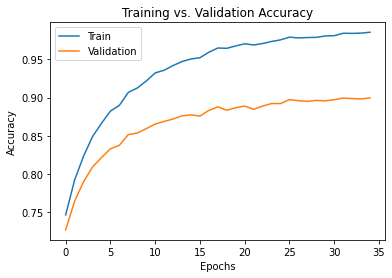

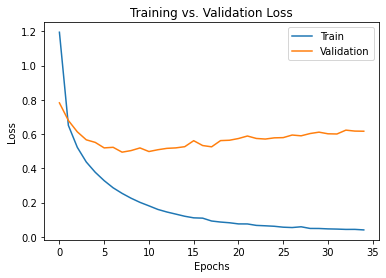

In [0]:
train(resNet18, train_loader, validation_loader, model_name = "resNet18", num_epochs=35, learning_rate=0.001)

In [0]:
#started 1:40
#89.5
#0.49
#model, train_loader, valid_loader, model_name, num_epochs=10, learning_rate=1e-3, weight_decay=0):

In [0]:
train(resNet18, train_loader, validation_loader, model_name = "resNet18", num_epochs=60, learning_rate=0.001)

In [0]:
#Load a pretrained model and reset final fully connected layer.
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

resNet50 = models.wide_resnet50_2(pretrained=True)
num_ftrs = resNet50.fc.in_features
# Here the size of each output sample is set to 369.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
resNet50.fc = nn.Linear(num_ftrs, 369)

resNet50 = resNet50.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(resNet18.parameters(), lr=0.001, momentum=0.9)

Downloading: "https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth" to /root/.cache/torch/checkpoints/wide_resnet50_2-95faca4d.pth


In [0]:
use_cuda = True

resNet50.cuda()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), strid

In [0]:
train(resNet50, train_loader, validation_loader, model_name = "resNet50", num_epochs=60, learning_rate=0.001)

Training started...
Epoch #0, Training Loss: 1.3820, Validation Loss: 0.8078
Epoch #0, Training Accuracy: 0.7381, Validation Accuracy: 0.7229
Epoch #1, Training Loss: 0.6854, Validation Loss: 0.6616
Epoch #1, Training Accuracy: 0.7856, Validation Accuracy: 0.7672
Epoch #2, Training Loss: 0.5542, Validation Loss: 0.6175
Epoch #2, Training Accuracy: 0.8088, Validation Accuracy: 0.7812
Epoch #3, Training Loss: 0.4726, Validation Loss: 0.5493
Epoch #3, Training Accuracy: 0.8370, Validation Accuracy: 0.8070
Epoch #4, Training Loss: 0.4130, Validation Loss: 0.5276
Epoch #4, Training Accuracy: 0.8516, Validation Accuracy: 0.8166
Epoch #5, Training Loss: 0.3691, Validation Loss: 0.5048
Epoch #5, Training Accuracy: 0.8665, Validation Accuracy: 0.8278
Epoch #6, Training Loss: 0.3331, Validation Loss: 0.4860
Epoch #6, Training Accuracy: 0.8788, Validation Accuracy: 0.8370
Epoch #7, Training Loss: 0.2950, Validation Loss: 0.4762
Epoch #7, Training Accuracy: 0.8855, Validation Accuracy: 0.8427
Epoc

## Analysis Functions

In [0]:
def prepare_full_accuracy(model, data_loader):
    '''
    Inputs: final model (i.e. trained weights) and data loader
    Note that this should be the validation or test loader
    Outputs: Based on the model and the validation / test set, it returns
    two lists: full_labels_list is a list of all of the true labels while
    full_pred_list is a list of all the corresponding predictions of the model
    Necessary to execute this for other analysis functions
    '''

    full_labels_list = []
    full_pred_list = []

    for imgs, labels in data_loader:
        
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
        
        mini_labels_list = []
        for i in range(len(labels)):
          mini_labels_list.append(int(labels[i]))

        full_labels_list.extend(mini_labels_list)

        output = model(imgs)

        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]

        mini_pred_list = []
        for j in range(len(pred)):
          mini_pred_list.append(int(pred[j]))

        full_pred_list.extend(mini_pred_list)

    return full_labels_list, full_pred_list

In [0]:
def full_accuracy_totals(y_true, y_pred):
  '''
  Inputs: Full lists of the actual labels and the predictions from prepare_full_accuracy()
  Returns: a dictionary with a mapping between each symbol and its: (1) prediction accuracy
  in the validation set, (2) total number of correct predictions, (3) total number of appearances.
  For prediction accuracy, this will report:
  In all cases where the symbol X was the true label, what % of the time did
  the model get it right
  '''
  master_dict = {}
  # First, get a set representation of y_true
  unique = np.unique(y_true)

  # Loop through unique
  for symbol in unique:
    # For each symbol, we will loop through all of y_true
    num_correct = 0
    total_instances = 0
    for i in range(len(y_true)):
      # Stop once we reach an element that matches the symbol
      if y_true[i] == symbol:
        # Increment total instances by 1
        total_instances += 1
        # Next, check to see if the corresponding prediction was correct 
        if y_true[i] == y_pred[i]:
          num_correct += 1
    # At the end of the loop compute and store num_correct, total, and accuracy
    accuracy = round(num_correct / total_instances, 4)
    master_dict[symbol] = (accuracy, num_correct, total_instances)

  return master_dict

In [0]:
def get_accuracy_symbol(master_dict, symbol_id):
  '''
  Assumes input of the master dictionary generated by full_accuracy_totals
  Returns accuracy for a given symbol
  '''

  return master_dict[symbol_id][0]

In [0]:
import operator

def plot_accuracy(master_dict):
  '''
  Input: results dictionary
  Output: produces a bar chart plot of overall accuracy for each class, and also sorted
  '''
  symbol_id_vals = []
  accuracy_vals = []

  # First, just plot it regularly (no sorting)
  for symbol in master_dict:
    symbol_id_vals.append(symbol)
    # Note that accuracy % is stored at position 0 in each entry
    accuracy_vals.append(master_dict[symbol][0])

  plt.title("Validation Accuracy by Symbol (ID)")
  plt.bar(symbol_id_vals, accuracy_vals)
  plt.xlabel("Symbol ID [0, 368]")
  plt.ylabel("Validation Accuracy [0, 1]")
  plt.show()

  # Get a sorted version of the dictionary
  sort_dict = sorted(master_dict.items(), key=operator.itemgetter(1))
  sorted_symbols = []
  sorted_acc = []
  # Iterate through and prep vectors for plotting
  for num in range(len(sort_dict)):
    sorted_symbols.append(sort_dict[num][0])
    sorted_acc.append(sort_dict[num][1][0])

  # Turn symbols list into strings
  sorted_symbols = [str(i) for i in sorted_symbols]
  plt.title("Sorted: Validation Accuracy by Symbol (ID)")
  plt.bar(sorted_symbols, sorted_acc)
  plt.xlabel ("Symbol ID [0, 368]")
  plt.ylabel("Validation Accuracy [0, 1]")
  plt.show()

In [0]:
import operator

def plot_X_accuracy(master_dict, X, direction):
  '''
  Plots the top/bottom X symbols and returns a list of their corresponding symbol ID's
  master_dict: dictionary containing full details on accuracy for each symbol 
  X: an integer indicating how many symbols you want to show
  direction: either "Top" or "Bottom" indicating which end of the distribution you want
  Note: also returns a list of symbol id's; can be easily used with get_symbol_LATEX to find
  which symbols the ID's represent
  '''
  # Get a sorted version of the dictionary
  sort_dict = sorted(master_dict.items(), key=operator.itemgetter(1))
  sorted_symbols = []
  sorted_acc = []
  # Iterate through and prep vectors for plotting
  for num in range(len(sort_dict)):
    sorted_symbols.append(sort_dict[num][0])
    sorted_acc.append(sort_dict[num][1][0])

  # Turn symbols list into strings
  sorted_symbols = [str(i) for i in sorted_symbols]

  if direction == "Bottom":
    true_sorted_symbols = sorted_symbols[0:X+1]
    true_sorted_acc = sorted_acc[0:X+1]
  if direction == "Top":
    true_sorted_symbols = sorted_symbols[-1*X:]
    true_sorted_acc = sorted_acc[-1*X:]
    
  plt.title("{} {} Symbols: Validation Accuracy by Symbol (ID)".format(direction, X))
  plt.bar(true_sorted_symbols, true_sorted_acc)
  plt.xlabel ("Symbol ID [0, 368]")
  plt.ylabel("Validation Accuracy [0, 1]")
  plt.show()

  # Before returning the symbols themselves, convert them back into ints
  true_sorted_symbols = [int(i) for i in true_sorted_symbols]

  return true_sorted_symbols

In [0]:
def get_symbol_LATEX(sym_id, dataset_obj):
  '''
  Retreives the LaTeX equivalent name for a symbol, given its ID
  # Note: look-up is based on *class_id* in the dataset
  '''
  df = dataset_obj.df

  for i in range(df.shape[0]):
    if df.iloc[i, 3] == sym_id:
      return df.iloc[i, 1] 
  
  return None

In [0]:
def sort_dictionary(master_dict):
  '''
  Input: results dictionary
  Output: returns the same dictionary, but sorted from lowest to highest accuracy
  '''
  sorted_list = sorted(master_dict.items(), key=lambda x: x[1])
  return sorted_list

In [0]:
def get_single_confusion(confusion, sym_id):
  '''
  Input: the confusion matrix and the numerical id for the symbol of interest
  Output: confusion analysis for that symbol
  '''
  
  print("\nThis symbol is: ", get_symbol_LATEX(sym_id, train_dataset))
  print("\nConfusion analysis:\n")

  nonzero_symbols = []
  
  size = confusion.shape[0]
  for j in range(size):
    value = confusion[sym_id][j]
    if value > 0:
      #symbols_map[j] = value
      nonzero_symbols.append(j)
  
  # Get the corresponding names
  names_list = []
  for num in nonzero_symbols:
    names_list.append(get_symbol_LATEX(num, train_dataset))
  
  # Finally, create a dictionary that is: name --> percentage
  return_dict = {}
  for i in range(len(nonzero_symbols)):
    return_dict[names_list[i]] = round(confusion[sym_id][nonzero_symbols[i]], 4)
    
  print(return_dict)
  return return_dict


In [0]:
class CNN_Deeper_v2(nn.Module):
    def __init__(self):
        super(CNN_Deeper_v2, self).__init__()
        self.name = "More_Conv2"
        self.conv1 = nn.Conv2d(1, 16, 3)   # Note: Only one input channel (gray scale)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.conv3 = nn.Conv2d(32, 64, 3)
        self.conv4 = nn.Conv2d(64, 128, 3)
        self.conv5 = nn.Conv2d(128, 256, 3)
        self.conv6 = nn.Conv2d(256, 340, 2)  #Might have to make a smaller kernel here (2x2?)

        self.fc1 = nn.Linear(340 * 2 * 2, 65)
        self.fc2 = nn.Linear(65, 369)

    def forward(self, img):
        x = F.relu(self.conv1(img))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = self.pool(F.relu(self.conv4(x)))
        x = F.relu(self.conv5(x))

        x = x.view(-1, 160 * 3 * 3)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [0]:
deeper_model = CNN_Deeper_v2()
use_cuda = True
deeper_model.cuda()

In [0]:
DATA_PATH = "/content/drive/My Drive/models/state_dicts/resnet50.pt"
resNet = open(DATA_PATH + "resnet50.pt")

In [0]:
class ResNet18(nn.Module):
    def __init__(self):
            super(ResNet18, self).__init__()
            self.name = "ResNet18"
            # fine tuning the ResNet helped significantly with the accuracy
            base_model = ResNet18(BasicBlock, [2, 2, 2, 2])
            base_model.load_state_dict(model_zoo.load_url('https://s3.amazonaws.com/pytorch/models/resnet18-5c106cde.pth'))
            # code needed to deactivate fine tuning of resnet
            #for param in base_model.parameters():
            #    param.requires_grad = False
            self.base_model = base_model
            self.drop0 = nn.Dropout2d(0.05)

            self.conv1 = nn.Conv2d(512, 256, 3, padding=1, bias=False)
            self.bn1 = nn.BatchNorm2d(256)
            self.drop1 = nn.Dropout2d(0.05)

            self.conv2 = nn.Conv2d(256, 128, 3, padding=1, bias=False)
            self.bn2 = nn.BatchNorm2d(128)
            self.drop2 = nn.Dropout2d(0.05)

            #self.conv3 = nn.Conv2d(128, 1+9, 3, padding=1, bias=False) 
            self.fc1 = nn.Linear(128, 65)
            self.fc2 = nn.Linear(65, 369)
    def forward(self, img):
        x = F.relu(self.conv1(img))
        x = self.pool(F.relu(self.conv2(x)))

        x = x.view(-1, 160 * 3 * 3)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [0]:
ResNet18 = ResNet18()
use_cuda = True
ResNet18.cuda()

In [0]:
state_dict = torch.utils.model_zoo.load_url("/content/drive/My Drive/models/state_dicts/resnet50.pt")

In [0]:
import torchvision.models as models

DATA_PATH = "/content/drive/My Drive/models/state_dicts/resnet50.pt"

resnet50 = models.resnet18(pretrained=True)
use_cuda = True
#resnet18.layer5 = nn.Conv2d(512,64,kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)        
resnet18.fc = nn.Linear(512, 64)
resnet18.fc2 = nn.Linear(64, 369)
resnet18.cuda()

In [0]:
train(resnet18, train_loader, validation_loader, model_name = "resNet18", num_epochs=35, learning_rate=0.001)

# Results Analysis

In [0]:
# Define the model path via early stopping
# Based on training, pick the model epoch that is best
# Check the files section on Colab to ensure that the model was saved for that epoch

# Things to change:
# 1) The model (1st parameter)
# 2) The epoch # (depends on where your best model was during training)
# batch size and learning rate, if you changed those parameters

path_test = get_model_name(model.name, batch_size=128, learning_rate=0.001, epoch=22)

In [0]:
# Load this older model's weights
# ALSO: Change the model class (i.e. "CNN_Deeper_v1()") to your model's class
# Easiest to just leave the name of the variable as "model" for the rest of this

# Instantiate a new empty model
model = CNN_Deeper_v1() 
# Load in its weights
model.load_state_dict(torch.load(path_test))
# RUN THIS STEP IF USING GPU
model.cuda()
model.eval()

In [0]:
# Take a peak at out of sample results...
get_accuracy(model, test_loader)

In [0]:
# Generate predictions
true_states, pred_states = prepare_full_accuracy(model, validation_loader)

In [0]:
# Get results dictionary
all_accuracy_dict = full_accuracy_totals(true_states, pred_states)

In [0]:
# Plot accuracy by class
plot_accuracy(all_accuracy_dict)

In [0]:
# Plot the top X classes --> leave at 15 for readability
best = plot_X_accuracy(all_accuracy_dict, 15, "Top")

In [0]:
# Get the worst X classes --> leave at 15 for readability
worst = plot_X_accuracy(all_accuracy_dict, 15, "Bottom")

In [0]:
# Sort and display all results by accuracy
sort_dictionary(all_accuracy_dict)

In [0]:
# Run this to faciliate later code
best = plot_X_accuracy(all_accuracy_dict, 50, "Top")

In [0]:
# Run this to faciliate later code
worst = plot_X_accuracy(all_accuracy_dict, 50, "Bottom")

In [0]:
# Print names of top 50 symbols
for i in best:
  print(get_symbol_LATEX(i, train_dataset))

In [0]:
# Print names of bottom 50 symbols
for j in worst:
  print(get_symbol_LATEX(j, train_dataset))

In [0]:
# Generate confusion matrix
matrix = confusion_matrix(true_states, pred_states, normalize='true')

In [0]:
# Output confusion analysis for each of the 50 worst symbols
for i in worst:
  get_single_confusion(matrix, i)